# LIBRARY

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

# IMPORT

In [44]:
# Load data
train = pd.read_csv('src/train.csv')
test = pd.read_csv('src/test.csv')

In [45]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39550 entries, 0 to 39549
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          39550 non-null  int64  
 1   person_age                  38465 non-null  float64
 2   person_income               38492 non-null  float64
 3   person_home_ownership       38459 non-null  object 
 4   person_emp_length           38507 non-null  float64
 5   loan_intent                 38501 non-null  object 
 6   loan_grade                  38457 non-null  object 
 7   loan_amnt                   38469 non-null  float64
 8   loan_int_rate               38473 non-null  float64
 9   loan_percent_income         38460 non-null  float64
 10  cb_person_default_on_file   38485 non-null  object 
 11  cb_person_cred_hist_length  38464 non-null  float64
 12  loan_status                 39550 non-null  int64  
dtypes: float64(7), int64(2), object

In [46]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16950 entries, 0 to 16949
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          16950 non-null  int64  
 1   person_age                  16637 non-null  float64
 2   person_income               16674 non-null  float64
 3   person_home_ownership       16627 non-null  object 
 4   person_emp_length           16635 non-null  float64
 5   loan_intent                 16667 non-null  object 
 6   loan_grade                  16639 non-null  object 
 7   loan_amnt                   16649 non-null  float64
 8   loan_int_rate               16654 non-null  float64
 9   loan_percent_income         16640 non-null  float64
 10  cb_person_default_on_file   16616 non-null  object 
 11  cb_person_cred_hist_length  16622 non-null  float64
dtypes: float64(7), int64(1), object(4)
memory usage: 1.6+ MB


# Clean Data

### Fill missing value

In [47]:
# Select categorical columns
cat_cols = test.select_dtypes(include=['object', 'category']).columns.tolist()

# Select numerical columns
numerical_cols = test.select_dtypes(include=['int64', 'float64']).columns.tolist()

print("Categorical Columns:", cat_cols)
print("Numerical Columns:", numerical_cols)

Categorical Columns: ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']
Numerical Columns: ['id', 'person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']


In [48]:
for col in cat_cols:
    train[col] = train[col].fillna(train[col].mode()[0])
    test[col] = test[col].fillna(test[col].mode()[0])

for col in numerical_cols:
    train[col] = train[col].fillna(train[col].median())
    test[col] = test[col].fillna(test[col].median())

In [49]:
# Drop unnecessary columns
drop_cols = ["id"]
train.drop(columns=drop_cols, inplace=True)
test.drop(columns=drop_cols, inplace=True)

In [50]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39550 entries, 0 to 39549
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  39550 non-null  float64
 1   person_income               39550 non-null  float64
 2   person_home_ownership       39550 non-null  object 
 3   person_emp_length           39550 non-null  float64
 4   loan_intent                 39550 non-null  object 
 5   loan_grade                  39550 non-null  object 
 6   loan_amnt                   39550 non-null  float64
 7   loan_int_rate               39550 non-null  float64
 8   loan_percent_income         39550 non-null  float64
 9   cb_person_default_on_file   39550 non-null  object 
 10  cb_person_cred_hist_length  39550 non-null  float64
 11  loan_status                 39550 non-null  int64  
dtypes: float64(7), int64(1), object(4)
memory usage: 3.6+ MB


In [51]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16950 entries, 0 to 16949
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  16950 non-null  float64
 1   person_income               16950 non-null  float64
 2   person_home_ownership       16950 non-null  object 
 3   person_emp_length           16950 non-null  float64
 4   loan_intent                 16950 non-null  object 
 5   loan_grade                  16950 non-null  object 
 6   loan_amnt                   16950 non-null  float64
 7   loan_int_rate               16950 non-null  float64
 8   loan_percent_income         16950 non-null  float64
 9   cb_person_default_on_file   16950 non-null  object 
 10  cb_person_cred_hist_length  16950 non-null  float64
dtypes: float64(7), object(4)
memory usage: 1.4+ MB


# Preprocess

### Outliers handle

In [52]:
# Select categorical columns
cat_cols = test.select_dtypes(include=['object', 'category']).columns.tolist()

# Select numerical columns
numerical_cols = test.select_dtypes(include=['int64', 'float64']).columns.tolist()

print("Categorical Columns:", cat_cols)
print("Numerical Columns:", numerical_cols)

Categorical Columns: ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']
Numerical Columns: ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']


In [53]:
def log_transformed(df, numerical_cols):
    df_log_transformed = df.copy()

    for col in numerical_cols:
        if df_log_transformed[col].min() > 0:
            df_log_transformed[col] = np.log(df_log_transformed[col] + 1)

    return df_log_transformed

In [54]:
train_log_transformed = log_transformed(train, numerical_cols)

In [55]:
test_log_transformed = log_transformed(test, numerical_cols)

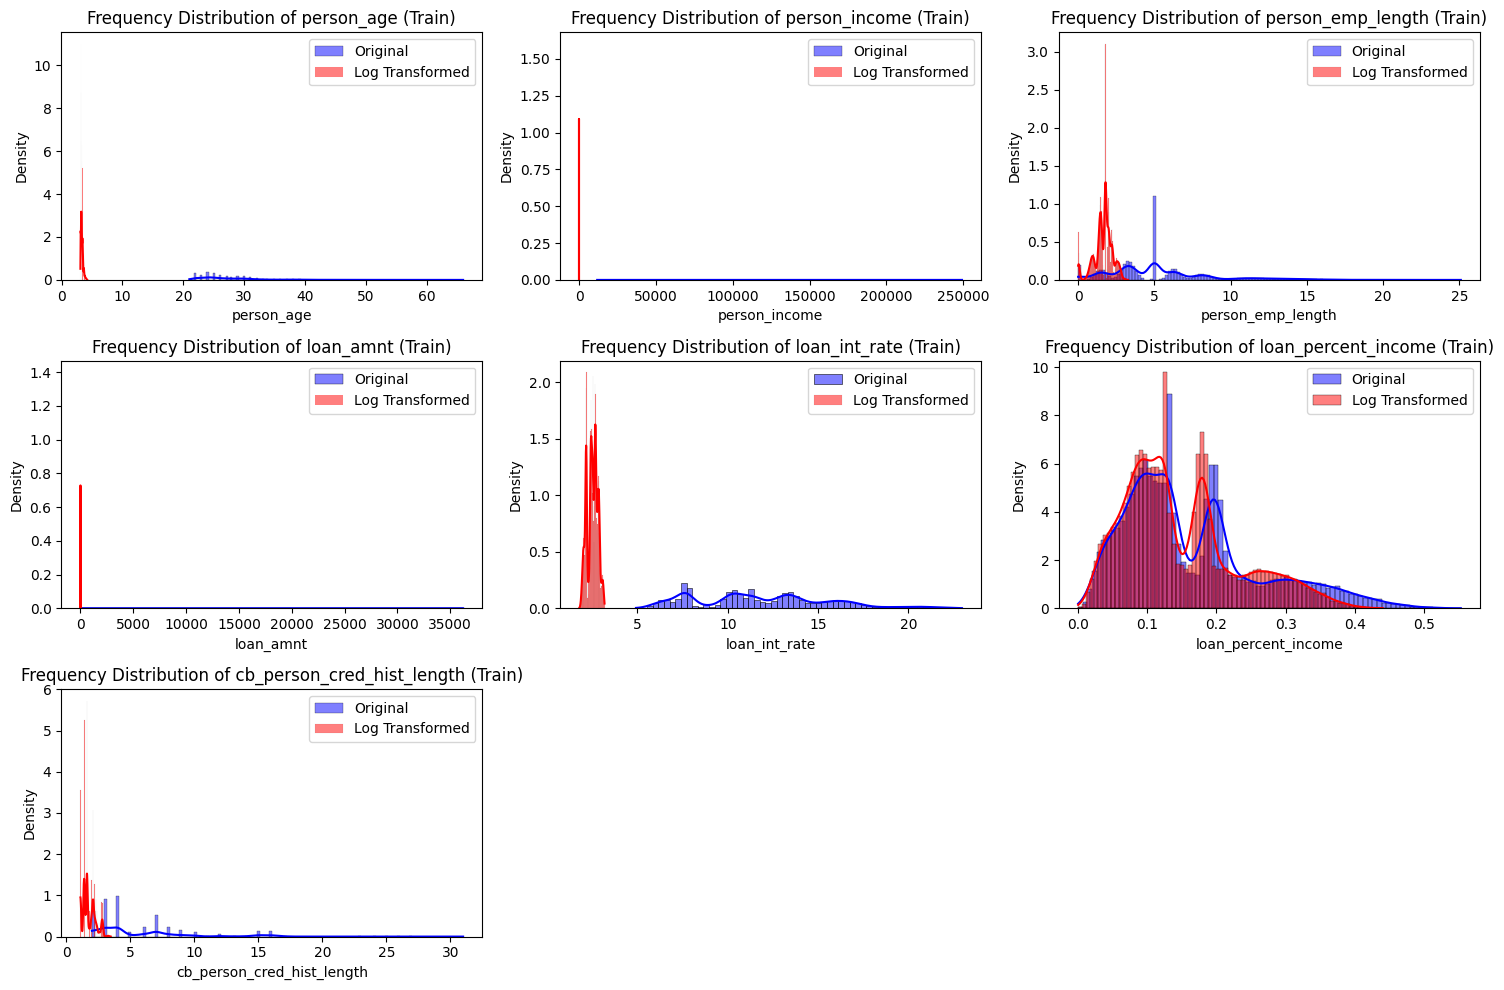

In [56]:
# Create subplots for train data
plt.figure(figsize=(15, 10))

for i, col in enumerate(numerical_cols, 1):
    plt.subplot(3, 3, i)

    # original train data
    sns.histplot(train[col], kde=True, color='blue', label='Original', stat="density")
    # log-transformed train data
    sns.histplot(train_log_transformed[col], kde=True, color='red', label='Log Transformed', stat="density")
    
    plt.title(f"Frequency Distribution of {col} (Train)")
    plt.xlabel(col)
    plt.ylabel("Density")
    plt.legend()

plt.tight_layout()
plt.show()

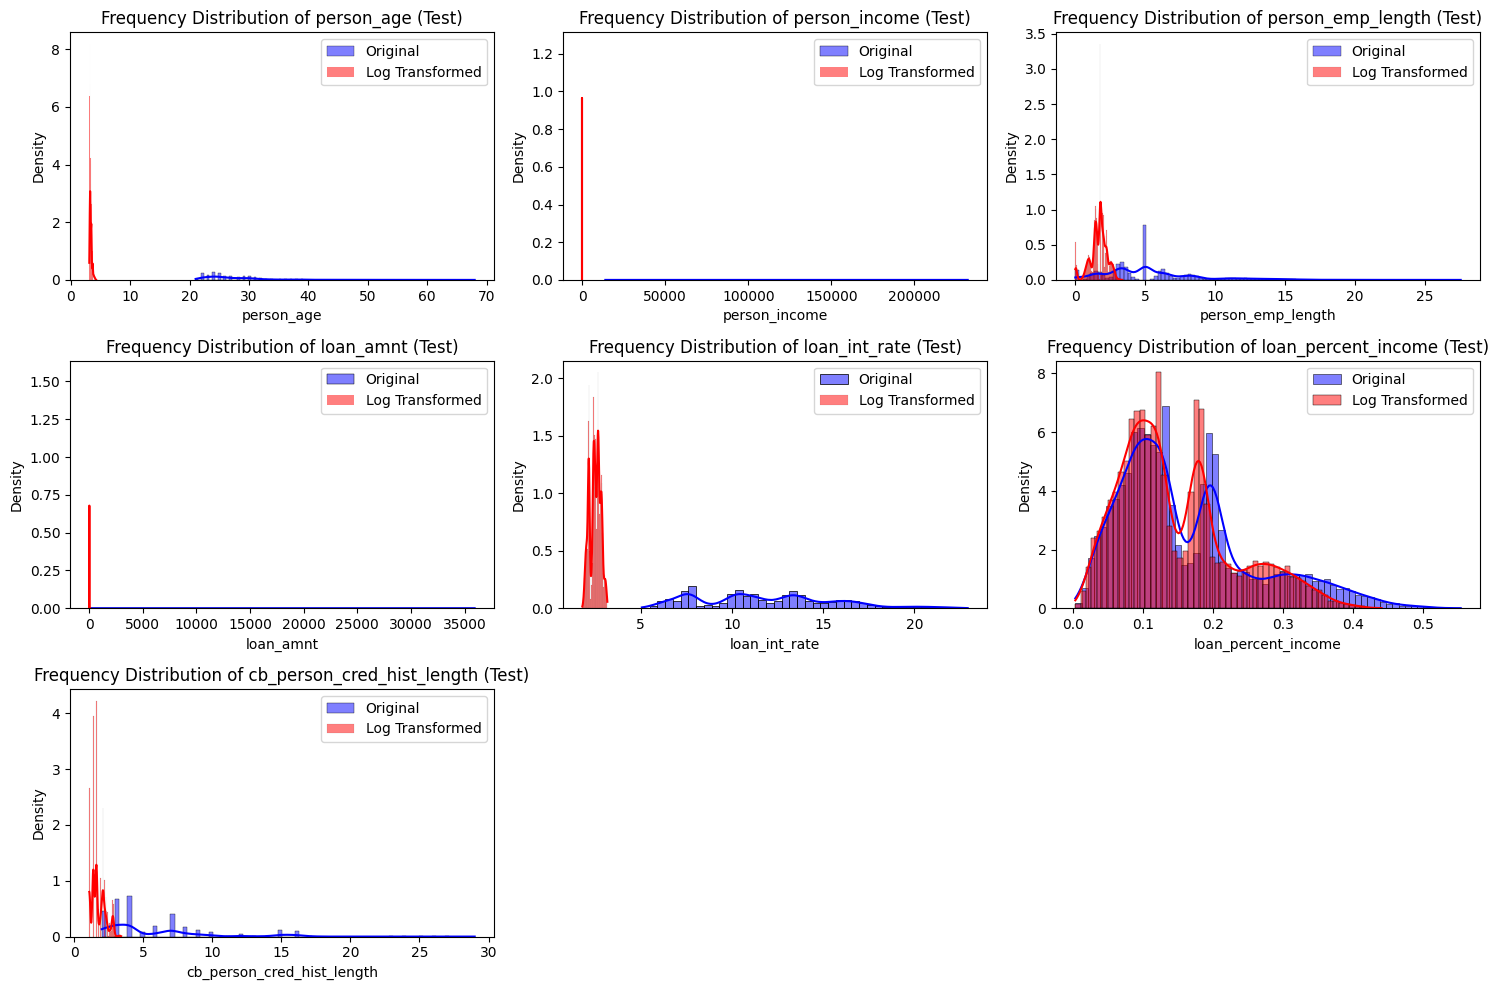

In [57]:
# Create subplots for test data
plt.figure(figsize=(15, 10))

for i, col in enumerate(numerical_cols, 1):
    plt.subplot(3, 3, i)

    # original test data
    sns.histplot(test[col], kde=True, color='blue', label='Original', stat="density")
    # log-transformed test data
    sns.histplot(test_log_transformed[col], kde=True, color='red', label='Log Transformed', stat="density")
    
    plt.title(f"Frequency Distribution of {col} (Test)")
    plt.xlabel(col)
    plt.ylabel("Density")
    plt.legend()

plt.tight_layout()
plt.show()

### Encode

In [58]:
# One-Hot Encoding for categorical variables
train_log_transformed = pd.get_dummies(train_log_transformed, columns=cat_cols, drop_first=True)
test_log_transformed = pd.get_dummies(test_log_transformed, columns=cat_cols, drop_first=True)

In [59]:
# Scale numerical features
scaler = MinMaxScaler()
num_features = test_log_transformed.select_dtypes(include=['int64', 'float64']).columns

train_log_transformed[num_features] = scaler.fit_transform(train_log_transformed[num_features])
test_log_transformed[num_features] = scaler.transform(test_log_transformed[num_features])

In [60]:
train_log_transformed

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status,person_home_ownership_OTHER,person_home_ownership_OWN,...,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_Y
0,0.183895,0.353459,0.594215,0.889675,0.521479,0.400528,0.215800,1,False,False,...,False,False,False,False,False,False,True,False,False,True
1,0.364087,0.671270,0.691051,0.894553,0.606972,0.381373,0.215800,0,False,False,...,False,False,True,True,False,False,False,False,False,False
2,0.150006,0.259847,0.545125,0.775717,0.734451,0.491002,0.121532,0,False,False,...,False,True,False,False,False,True,False,False,False,True
3,0.039915,0.338276,0.456140,0.810540,0.435187,0.410392,0.215800,0,False,False,...,False,False,False,False,False,False,False,False,False,False
4,0.114788,0.480131,0.412644,0.697255,0.639007,0.386417,0.000000,1,False,False,...,False,False,False,False,True,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39545,0.307947,0.923891,0.828014,0.667931,0.775072,0.278467,0.414355,0,False,False,...,False,False,False,False,True,False,False,False,False,False
39546,0.000000,0.618249,0.600107,0.850336,0.487974,0.401445,0.000000,0,False,False,...,False,False,False,True,False,False,False,False,False,False
39547,0.278503,0.456886,0.592055,0.891974,0.553108,0.651206,0.414355,1,False,False,...,False,True,False,False,True,False,False,False,False,True
39548,0.078132,0.244904,0.545684,0.716255,0.789459,0.471866,0.121532,1,False,False,...,False,True,False,False,False,True,False,False,False,True


In [61]:
test_log_transformed

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,...,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_Y
0,0.039915,0.312081,0.606086,0.896082,0.698159,0.727785,0.215800,False,False,True,...,True,False,False,False,True,False,False,False,False,True
1,0.336455,0.626383,0.731644,0.804634,0.472973,0.288661,0.548887,False,False,False,...,False,False,True,False,False,False,False,False,False,False
2,0.150006,0.273688,0.396360,0.746156,0.708275,0.080273,0.215800,False,False,True,...,True,False,False,False,True,False,False,False,False,False
3,0.150006,0.492998,0.697696,0.927287,0.297544,0.280154,0.215800,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,0.216551,0.657677,0.548579,0.687180,0.122515,0.140166,0.000000,False,False,False,...,False,True,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16945,0.078132,0.469401,0.545938,0.804531,0.628465,0.392410,0.215800,False,False,True,...,False,False,False,False,False,True,False,False,False,False
16946,0.307947,0.569047,0.781827,0.660285,0.768948,0.196315,0.464113,False,False,False,...,False,False,False,False,False,True,False,False,False,True
16947,0.364087,0.358682,0.768413,0.723867,0.511537,0.417240,0.357944,False,False,True,...,False,False,True,False,True,False,False,False,False,False
16948,0.039915,0.475745,0.011502,0.804899,0.536214,0.467633,0.215800,True,False,False,...,False,False,False,True,False,False,False,False,False,False


### Imbalancing

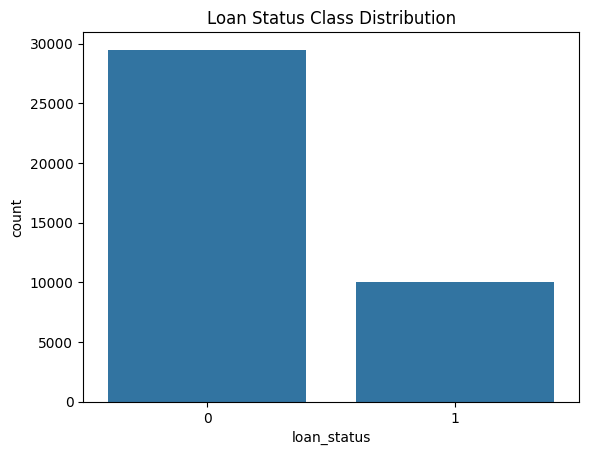

In [62]:
sns.countplot(x=train_log_transformed['loan_status'])
plt.title("Loan Status Class Distribution")
plt.show()

In [63]:
# Target & Features
X = train_log_transformed.drop(columns=['loan_status'])
y = train_log_transformed['loan_status']

# Handle class imbalance
class_counts = y.value_counts()
class_weights = {0: class_counts[1] / len(y), 1: class_counts[0] / len(y)}

In [64]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39550 entries, 0 to 39549
Data columns (total 22 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   person_age                   39550 non-null  float64
 1   person_income                39550 non-null  float64
 2   person_emp_length            39550 non-null  float64
 3   loan_amnt                    39550 non-null  float64
 4   loan_int_rate                39550 non-null  float64
 5   loan_percent_income          39550 non-null  float64
 6   cb_person_cred_hist_length   39550 non-null  float64
 7   person_home_ownership_OTHER  39550 non-null  bool   
 8   person_home_ownership_OWN    39550 non-null  bool   
 9   person_home_ownership_RENT   39550 non-null  bool   
 10  loan_intent_EDUCATION        39550 non-null  bool   
 11  loan_intent_HOMEIMPROVEMENT  39550 non-null  bool   
 12  loan_intent_MEDICAL          39550 non-null  bool   
 13  loan_intent_PERS

# Training

In [65]:
clf = lgb.LGBMClassifier(
    class_weight=class_weights,
    random_state=42
)

clf.fit(X, y)

[LightGBM] [Info] Number of positive: 10053, number of negative: 29497
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000755 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1377
[LightGBM] [Info] Number of data points in the train set: 39550, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


LGBMClassifier(class_weight={0: np.float64(0.25418457648546144),
                             1: np.float64(0.7458154235145386)},
               random_state=42)

# Predicting

In [66]:
y_pred = clf.predict(test_log_transformed)
y_pred

array([1, 0, 1, ..., 0, 1, 0], shape=(16950,))

# Submit

In [67]:
submit_df = pd.read_csv('src/sample_submission.csv')
submit_df

,id,loan_status
0,39550,1.0
1,39551,0.0
2,39552,1.0
3,39553,NaN
4,39554,NaN
...,...,...
16945,56495,NaN
16946,56496,NaN
16947,56497,NaN
16948,56498,NaN


In [68]:
submit_df['loan_status'] = y_pred

In [69]:
submit_df.to_csv('submission.csv', index=False)

submit_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16950 entries, 0 to 16949
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   id           16950 non-null  int64
 1   loan_status  16950 non-null  int64
dtypes: int64(2)
memory usage: 265.0 KB


# Other

In [70]:
current_submit_df = pd.read_csv('submission.csv')
best_submit_df = pd.read_csv('submission0.68964.csv')

In [71]:
current_submit_df

,id,loan_status
0,39550,1
1,39551,0
2,39552,1
3,39553,0
4,39554,0
...,...,...
16945,56495,1
16946,56496,0
16947,56497,0
16948,56498,1


In [72]:
best_submit_df

,id,loan_status
0,39550,1
1,39551,0
2,39552,1
3,39553,0
4,39554,0
...,...,...
16945,56495,1
16946,56496,0
16947,56497,0
16948,56498,1


In [73]:
# Initialize a counter for differences
diff_count = 0

# Iterate over all rows
for i in range(len(current_submit_df)):
    # Get loan_status values for the current row in both dataframes
    current_loan_status = current_submit_df.iloc[i]['loan_status']
    best_loan_status = best_submit_df.iloc[i]['loan_status']
    
    # Compare the loan_status values
    if current_loan_status != best_loan_status:
        # Print the id and the differing loan_status
        id_value = current_submit_df.iloc[i]['id']
        print(f"Id: {id_value} has different loan_status values -> Current: {current_loan_status}, Best: {best_loan_status}")
        diff_count += 1

# Print total number of differences
print(f"Total differences: {diff_count}")


Total differences: 0
